In [1]:
import pathlib
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import h5py
import pandas as pd

from astropy.table import Table, vstack
from astropy.io import fits

In [2]:
gaia_source_path = pathlib.Path("/mnt/ceph/users/gaia/dr3/hdf5/GaiaSource")
files = sorted(gaia_source_path.glob("*.hdf5"))
len(files)

3386

8
768


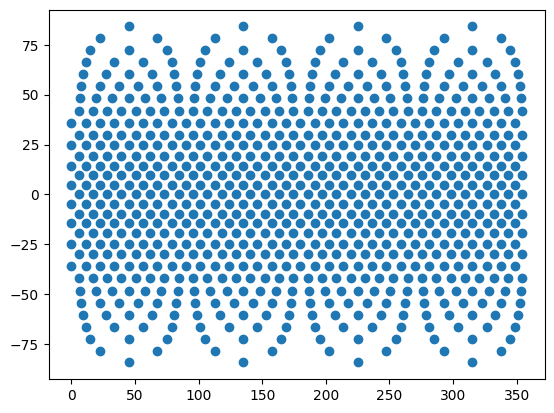

In [3]:
level = 3
nside = hp.order2nside(level)
pix_ctr = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True) # ang. coordinates of pixels
plt.scatter(pix_ctr[0], pix_ctr[1])

print(nside)
print(hp.nside2npix(nside)) # number of pixels for given nside

In [4]:
# radius of a pixel area if we approximate it as a circle
print(np.sqrt(hp.nside2pixarea(nside, degrees=True)/np.pi))

# angular separation of two stars separated by 4 pc that are 50 pc away?
print((4 * u.pc / (50 * u.pc)).to(u.deg, equivalencies=u.dimensionless_angles()))

4.13496671566344
4.583662361046586 deg


In [ ]:
# load all Gaia data you need and store
print(len(files))

dfs_gaia_source = []
for single_file in files[0:10]: # subset for now
    gaia_source = Table()
    with h5py.File(single_file, "r") as f:
        for col in ["source_id", "ra", "ra_error", "dec", "dec_error", "parallax", "parallax_error",\
                    "pmra", "pmra_error", "pmdec", "pmdec_error", "phot_g_mean_mag", "phot_bp_mean_mag",\
                        "phot_rp_mean_mag", "radial_velocity", "radial_velocity_error"]:
            gaia_source[col] = np.array(f[col][:])
    df_gaia_source = gaia_source.to_pandas()
    dfs_gaia_source.append(df_gaia_source)

gaia_source = pd.concat(dfs_gaia_source,ignore_index=True)

3386


In [6]:
# healpix level for each star (new column)
pd.options.mode.copy_on_write = True

level = 3
nside = hp.order2nside(level)
gaia_source["hp_pix_"+str(level)] = (gaia_source["source_id"] / (2**35 * 4**(12-level))).astype(int)

In [8]:
# --- cuts on primaries ---
# El-Badry+2021 quality cuts - only apply to primaries
primaries = gaia_source[(gaia_source['parallax']>1) & (gaia_source['parallax_error']<2) & \
                          (gaia_source['phot_g_mean_mag']!=np.nan)]                     
primaries = primaries[primaries['parallax_error']/primaries['parallax']<0.2] 

primaries['Gmag'] = primaries['phot_g_mean_mag']-5*np.log10(1/(primaries['parallax']*1e-3))+5

primaries = primaries[np.isfinite(primaries['phot_bp_mean_mag']) & \
                          np.isfinite(primaries['phot_rp_mean_mag']) & np.isfinite(primaries['Gmag'])]

In [ ]:
for i,row in primaries.iterrows():
    this_pix = int(row[f"hp_pix_{level}"]) # iterrows turns everything into float64, so have to recast
    other_pix = hp.get_all_neighbours(nside, this_pix, nest=True) # get nside=8 nearest pixels
    
    mask = np.isin(
        gaia_source[f"hp_pix_{level}"], np.concatenate(([this_pix], other_pix))
    )

    subset = gaia_source[mask]

    # ^^ how do we separate this into primaries and (potential) secondaries?

    # TODO: compute sky separation, El-Badry criteria (loosened), ∆G, ∆G-RP'''

[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False False]
[ True  True  True ... False False

KeyboardInterrupt: 

In [5]:
# load all Gaia data you need and store
print(len(files))

dfs_gaia_source = []
for single_file in files[0:10]:
    gaia_source = Table()
    with h5py.File(single_file, "r") as f:
        for col in ["source_id", "ra", "ra_error", "dec", "dec_error", "parallax", "parallax_error",\
                    "pmra", "pmra_error", "pmdec", "pmdec_error", "phot_g_mean_mag", "phot_bp_mean_mag",\
                        "phot_rp_mean_mag", "radial_velocity", "radial_velocity_error"]:
            gaia_source[col] = np.array(f[col][:])
    df_gaia_source = gaia_source.to_pandas()
    dfs_gaia_source.append(df_gaia_source)

df_gaia_final = pd.concat(dfs_gaia_source,ignore_index=True)
print(len(df_gaia_final))
print(df_gaia_final)

t = Table.from_pandas(df_gaia_final)
t.write('files/gaia_source_test.fits', overwrite=True)

3386
5188367
                  source_id         ra  ra_error        dec  dec_error  \
0                4295806720  44.996155  0.101618   0.005615   0.101334   
1               34361129088  45.004320  0.097320   0.021048   0.101753   
2               38655544960  45.004978  0.017885   0.019880   0.018772   
3              309238066432  44.995037  0.322039   0.038152   0.283505   
4              343597448960  44.963896  0.117176   0.043595   0.109004   
...                     ...        ...       ...        ...        ...   
5188362  149700642720761600  65.547640  0.304655  25.424482   0.175340   
5188363  149700642721615872  65.549063  0.845679  25.425891   0.461440   
5188364  149700642723462272  65.546548  0.026780  25.425415   0.014603   
5188365  149700642723462400  65.547856  0.131617  25.424251   0.072582   
5188366  149700672786050176  65.568570  0.650778  25.429543   0.319967   

         parallax  parallax_error       pmra  pmra_error      pmdec  \
0        0.354331        0.